In [436]:
#Load usual suspects
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
import itertools
import warnings
warnings.filterwarnings(action='ignore') #check for warnings to pop-out in jupyter. All of them are harmless though, and do not affect the outcome of this work. The lines where they occur are indicated in the code 

In [437]:
#Define all the functions that we are going to need:

#z scores
def z_score(x): 
    return (x - np.mean(x, axis=0))/np.std(x, axis=0) #add axis=0 so that the z_score is computed for each column in case the input array has several columns

#RMSLE values
def RMSLE(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

#MAE values
def MAE(y, y_pred):
    return np.mean(np.abs(10**y - 10**(y_pred))) #takes into account that y_pred is computed in log10

In [438]:
#for data loading and cleaning. All these decisions will be further commented step by step and in detail. The resulting dataframes obtained by either method (using the function or after successive steps) are the same, and this can be checked by running df1.equals(df2) which throws a 'True' evaluation.
def data_cleaning(x):
    to_replace = ['Alley', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature']
    replacements = ['NAA', 'NB', 'NB', 'NB', 'NB', 'NB', 'NF', 'NG', 'NG', 'NG', 'NG', 'NP', 'NF', 'NMF']
    mapping = dict(zip(to_replace, replacements))
    x = x.replace(np.nan, mapping)
    x.loc[x['Alley']=='NAA'] = x.replace(np.nan, {'Lot Frontage': 0.})
    x.loc[x['Garage Type']=='NG'] = x.replace(np.nan, {'Garage Yr Blt': 0.})
    x.loc[x['Bsmt Qual']=='NB'] = x.replace(np.nan, {'Bsmt Full Bath': 0.})
    x.loc[x['Bsmt Qual']=='NB'] = x.replace(np.nan, {'Bsmt Half Bath': 0.})
    x.loc[x['Bsmt Qual']=='NB'] = x.replace(np.nan, {'BsmtFin SF 1': 0})
    x.loc[x['Bsmt Qual']=='NB'] = x.replace(np.nan, {'BsmtFin SF 2': 0.})
    x.loc[x['Bsmt Qual']=='NB'] = x.replace(np.nan, {'Bsmt Unf SF': 0.})
    x.loc[x['Bsmt Qual']=='NB'] = x.replace(np.nan, {'Total Bsmt SF': 0.})
    y = x.copy()
    return y

In [439]:
#for data engineering and transformations. All these decisions will be further commented step by step and in detail. The resulting dataframes obtained by either method (using the function or after successive steps) are the same, and this can be checked by running df1.equals(df2) which throws a 'True' evaluation.
def data_engineering(x):
    x['Room area'] = x['Gr Liv Area']/x['TotRms AbvGrd']
    x['BedBath ratio'] = (x['Full Bath'] + x['Half Bath'])/(x['Bedroom AbvGr']+1)
    log_transform = ['Lot Area', '1st Flr SF', 'Gr Liv Area', 'Room area']
    sqroot_transform = ['Lot Frontage', 'Bsmt Unf SF', 'Total Bsmt SF', 'Garage Area', 'BedBath ratio']
    x[log_transform] = np.log10(x[log_transform])
    x[sqroot_transform] = np.sqrt(x[sqroot_transform])
    to_convert = ['MS SubClass', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Mo Sold', 'Yr Sold', 'Garage Yr Blt']
    remap = dict(zip(to_convert, np.array(len(to_convert) * [object])))
    x = x.astype(remap)
    return x

In [440]:
#for fine cleaning - getting rid of remaining NAs in the test set and of outliers in the training one.
def fine_cleaning(x):
    x = x.dropna(how='any', axis=0) #to be used in the cleaning and reorg of the input data. 
    x = x.loc[(z_score(x['LogSalePrice'])<2.8) & (z_score(x['LogSalePrice'])>(-3.0)),:] #outlier removal as discussed below
    return x 

def fine_cleaning_test(x):
    x = x.fillna(x.median()) #to be used in the preparation of the test set for predictions.
    return x

In [441]:
#before re-splitting the data into train and test based on PID (that is one of the reasons why PID was kept during all these operations). we will apply one-hot encoding of the variables based on the type of model to ensure that all the factors are present in both the train and test sets.
def onehot_encoding(model, df, df_test): #inputs are a string with the model ('simple', 'intermediate' or 'complex') and the train and test dataframes prior to cleaning
    simple = ['PID', 'Room area', 'Neighborhood'] #simple model with two variables. In this case, and to choose a different set of variables compared to the ones suggested by the author, we will build a model based on the 'Room area' we engineered and the 'Neighborhood'
    intermediate = ['PID', 'Room area', 'MS SubClass', 'Neighborhood', 'Lot Area', 'Street', 'Utilities', 'Bldg Type', 'Overall Cond', 'Year Built', 'Exter Cond', 'Total Bsmt SF', 'Heating', 'Gr Liv Area', 'TotRms AbvGrd', 'Garage Cars', 'Sale Condition'] #intermediate model with 10-20 variables.
    complex_mod = list(df.drop(columns=['Order', 'SalePrice']).columns) + ['Room area', 'BedBath ratio'] #complex model with all variables except Order and SalePrice (to avoid spurious columns in the test dataframe)
    x = pd.merge(df, df_test, how='outer')
    x = data_engineering(data_cleaning(x))
    if model == 'simple':
        x = x[simple]
    elif model == 'intermediate': 
        x = x[intermediate]
    elif model == 'complex':
        x = x[complex_mod]
    x = pd.get_dummies(x) 
    x_train = x[x['PID'].isin(df['PID'])]
    x_train = pd.merge(x_train, df[['PID', 'SalePrice']], how='outer')
    x_train.loc[:,'LogSalePrice'] = np.log10(x_train.loc[:,'SalePrice']+1)
    x_train = fine_cleaning(x_train)
    x_test = x[x['PID'].isin(df_test['PID'])]
    x_test = fine_cleaning_test(x_test)
    return [x_train, x_test]

In [442]:
#define the training and test sets depending on the model
def tt_split(df_ohe, test_size): #inputs are the one-hot encoded dataframe and the test size
    X = df_ohe.drop(['SalePrice', 'LogSalePrice'], axis=1).values #all the variables except the target one and the Sale Price. PID and Order are not included in any of the models.
    y = df_ohe.LogSalePrice.values #target value
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, random_state=0)
    return [X_tr, X_te, y_tr, y_te]

#fit several regressions to the data depending on the model (which is implicitly included in the one-hot encoded dataframe)
def regressions(df_ohe, test_size):
    X_tr = tt_split(df_ohe, test_size)[0] #feature variables, training set
    X_te = tt_split(df_ohe, test_size)[1] #feature variables, test set
    y_tr = tt_split(df_ohe, test_size)[2] #target variable, training set
    y_te = tt_split(df_ohe, test_size)[3] #target variable, test set
    lr = LinearRegression().fit(X_tr, y_tr) #linear regression
    huber = HuberRegressor(epsilon=1.35).fit(X_tr, y_tr) #regression with huber cost function. We have also tried to optimize the epsilon value by running a sweep like for the alpha values of ridge, but no improvements were found, and all the optimized huber cases had RMSLE and MAE larger than the baseline. 
    
    alphas = np.logspace(-20, 20, num=500) #generate an alpha array with 500 values in logscale (from 10^-20 to 10^20). This will be done to refine the ridge regression. The interval is kept sufficiently large to cater for all behaviours of the rmsle.
    rmsle_tr = [] #empty list that will be filled with the train set rmsle values in the for loop
    rmsle_te = [] #empty list that will be filled with the test set rmsle values in the for loop

    for alpha in alphas: #run through the alpha values
        ridge = Ridge(alpha=alpha).fit(X_tr, y_tr) 
        rmsle_values_tr = RMSLE(y_tr, ridge.predict(X_tr)) #calculate corresponding rmse for train set
        rmsle_tr.append(rmsle_values_tr) #append to rmse train array
        rmsle_values_te = RMSLE(y_te, ridge.predict(X_te)) #calculate corresponding rmse for test set
        rmsle_te.append(rmsle_values_te) #append to rmse test array
    
    best_alpha = alphas[np.argmin(rmsle_te)] #extract best alpha that yields the minimum corresponding value for the test set mse
    ridge = Ridge(alpha=best_alpha).fit(X_tr, y_tr) #apply ridge regression
    
    rmsle_train = [RMSLE(y_tr, np.mean(y_tr))] #start populating with the baseline value (mean)
    rmsle_test = [RMSLE(y_te, np.mean(y_te))] #start populating with the baseline value (mean)
    mae_train = [MAE(y_tr, np.median(y_tr))] #start populating with the baseline value (median)
    mae_test = [MAE(y_te, np.median(y_te))] #start populating with the baseline value (median)
    
    for i in [lr, huber, ridge]: #add
        fit_rmsle_tr = RMSLE(y_tr, i.predict(X_tr))
        rmsle_train.append(fit_rmsle_tr)
        fit_rmsle_te = RMSLE(y_te, i.predict(X_te))
        rmsle_test.append(fit_rmsle_te)
        fit_mae_tr = MAE(y_tr, i.predict(X_tr))
        mae_train.append(fit_mae_tr)
        fit_mae_te = MAE(y_te, i.predict(X_te))
        mae_test.append(fit_mae_te)
    
    return [[lr, huber, ridge, best_alpha], [rmsle_train, rmsle_test], [mae_train, mae_test], [alphas, rmsle_tr, rmsle_te]]

In [443]:
#Load data, both training and test sets
house_prices_original = pd.read_csv('~/Desktop/EPFL Applied ML/house-prices.csv') #load data
hp_500 = pd.read_csv('~/Desktop/EPFL Applied ML/house-prices-test.csv') #load test set

In [444]:
#to fit the three models, we will need to use categorical variables at some point. 
#the problem is that we cannot ensure that all the factors from these categorical variables will be present after one-hot encoding, leading to an impossibility to predict the house prices based on the models selected.
#for that purpose, the cleaning operations that have an effect on categorical factors will be performed on a merged version of the train and test sets, so that we can devise a pre-cleaning procedure for any type of feature selected for the model. In any case, no variable or observation will be dropped during this cleaning stage.
#the dataframe will be splitted back based on the PID of the different observations after these operations and further cleaning (outlier removal etc) will be performed separately.
#also, for consistency, the SalesPrice column will be dropped from the original dataframe and re-inserted afterwards.
hf = pd.merge(house_prices_original.drop(columns=['SalePrice']), hp_500, how='outer') #merge both dataframes as a starting point

In [445]:
#Check which features have an unusually high number of NaNs
print(hf.isnull().sum()[hf.isnull().sum()>0.93*len(hf)])
#it seems that we can happily drop 'Alley', 'Pool QC' and 'Misc Feature' as these features are mostly NaN values (at least 93%). The next feature, 'Fence', is 79% NaN, and the following one is 'Fireplace Qu' at 48% NaN.
#Note: a peek at the variable description shows that 'NA' values for these columns are not exactly a 'not acquired', but they include some meaning, such as 'No alley access', 'No pool', 'No fence', 'No fireplace' or 'None'. 
#therefore, we cannot drop these variables so happily. What we will do instead is to go back to the description and fetch all the columns where 'NA' is an actual factor, and replace them for a specific value.

Alley           2732
Pool QC         2917
Misc Feature    2824
dtype: int64


In [446]:
#The following features were identified as including 'NA' which should actually be factors:
to_replace = ['Alley', 'Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2', 'Fireplace Qu', 'Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature']
#the NA values will be replaced by the following ones, which are acronyms of 'no alley access', 'no basement', 'no pool', etc...
replacements = ['NAA', 'NB', 'NB', 'NB', 'NB', 'NB', 'NF', 'NG', 'NG', 'NG', 'NG', 'NP', 'NF', 'NMF']
mapping = dict(zip(to_replace, replacements)) #create a dictionary to replace the NaN
hf = hf.replace(np.nan, mapping) #replace the NaNs with the values from the dictionary
#house_prices = house_prices_original.fillna(mapping, axis=0) #at first I had a try with fillna, but when NA values were dropped in subsequent steps, Python would recognize the filled values as NaN even if they had been filled with other values.
#nans = np.array(len(to_replace) * [np.nan]) #create an list of nans to be used as target values for replacement

In [447]:
print(hf.isnull().sum()[hf.isnull().sum()>0]) #print the remaining features with NaNs. 
#It seems that the only ones which might cause trouble in terms of pre-cleaning are 'Lot Frontage' and 'Garage Yr Blt'.

Lot Frontage      490
Mas Vnr Type       23
Mas Vnr Area       23
BsmtFin SF 1        1
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Electrical          1
Bsmt Full Bath      2
Bsmt Half Bath      2
Garage Yr Blt     159
Garage Cars         1
Garage Area         1
dtype: int64


In [448]:
#by reading the definitions from documentation file, we can see that the bulk of the Lot Frontage values that are NaN correspond to cases where there is no alley access to the property, independently on the street access.
hf[hf['Lot Frontage'].isnull()].groupby(['Alley', 'Street']).size()

Alley  Street
Grvl   Pave        6
NAA    Grvl        2
       Pave      475
Pave   Pave        7
dtype: int64

In [449]:
#since the Lot Frontage is defined as 'Linear feet of street connected to property', we can set it to zero for the cases where there is no alley access (zero is actually a value which is not found in the original Lot Frontage values).
hf.loc[hf['Alley']=='NAA'] = hf.replace(np.nan, {'Lot Frontage': 0.})

In [450]:
#same story for the 'Garage Yr Blt' feature: we can see that in most of the cases, when there is no year it means that there is no garage at all.
hf[hf['Garage Yr Blt'].isnull()].groupby(['Garage Type', 'Garage Finish', 'Garage Qual', 'Garage Cond']).size()

Garage Type  Garage Finish  Garage Qual  Garage Cond
Detchd       NG             NG           NG               2
NG           NG             NG           NG             157
dtype: int64

In [451]:
#In this second case we can substitute the NaN with zero - this will be converted to factors further down for analysis:
hf.loc[hf['Garage Type']=='NG'] = hf.replace(np.nan, {'Garage Yr Blt': 0.})
print(hf.isnull().sum()[hf.isnull().sum()>0])

Lot Frontage      13
Mas Vnr Type      23
Mas Vnr Area      23
BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Electrical         1
Bsmt Full Bath     2
Bsmt Half Bath     2
Garage Yr Blt      2
Garage Cars        1
Garage Area        1
dtype: int64


In [452]:
#We can also see that the Bsmt Full and Half Bath, BsmtFin SF1 and 2, Bsmt Unf SF and Total Bsmt SF correspond to cases where there is no basement (can be checked by evaluating house_prices[house_prices['Bsmt Half Bath'].isnull()].groupby(['Bsmt Qual', 'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2']).size()), so a zero should be allocated to the NaN values in these cases.
hf.loc[hf['Bsmt Qual']=='NB'] = hf.replace(np.nan, {'Bsmt Full Bath': 0.})
hf.loc[hf['Bsmt Qual']=='NB'] = hf.replace(np.nan, {'Bsmt Half Bath': 0.})
hf.loc[hf['Bsmt Qual']=='NB'] = hf.replace(np.nan, {'BsmtFin SF 1': 0})
hf.loc[hf['Bsmt Qual']=='NB'] = hf.replace(np.nan, {'BsmtFin SF 2': 0.})
hf.loc[hf['Bsmt Qual']=='NB'] = hf.replace(np.nan, {'Bsmt Unf SF': 0.})
hf.loc[hf['Bsmt Qual']=='NB'] = hf.replace(np.nan, {'Total Bsmt SF': 0.})
print(hf.isnull().sum()[hf.isnull().sum()>0])

Lot Frontage     13
Mas Vnr Type     23
Mas Vnr Area     23
Electrical        1
Garage Yr Blt     2
Garage Cars       1
Garage Area       1
dtype: int64


In [453]:
#this is as far as we can get before making some further general cleaning assumptions on the merged dataframe (dropping values, filling with the mean, etc). 
#we will need to come back to this point after making some other decisions related to feature transformation or outlier removal based on the information contained only in the training set.

In [454]:
#using only the training set, we will check for swekedness and see if we can 'normalize' the continuous/int variables via some operations.
#before we will need some prior finer cleaning like outlier removal and observation dropping.
house_prices_original.loc[:,'LogSalePrice'] = np.log10(house_prices_original.loc[:,'SalePrice']+1) #added 1 to avoid division by zero (impossible in this case, but good practice though)
hp = data_cleaning(house_prices_original) #apply the cleaning procedure to the original dataframe
hp = hp.dropna(how='any', axis=0) #drop rows with any NaN - final shape 2395 x 83, so still retaining 98.6% of the observations

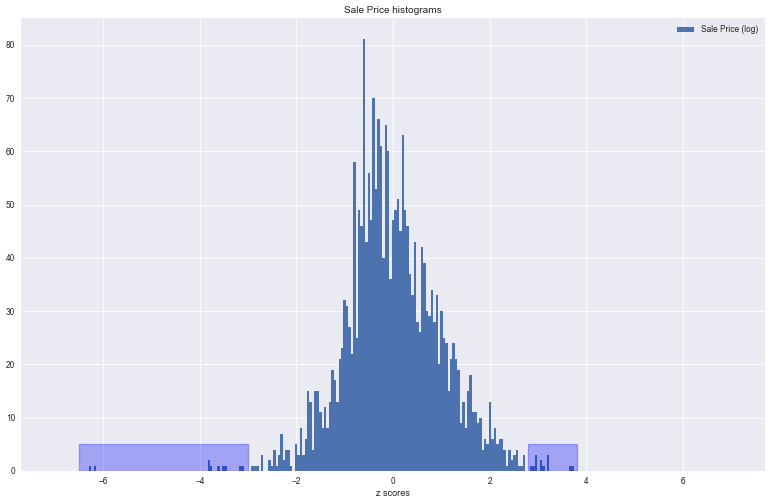

In [455]:
#for outlier removal, we will focus on whether the LogSalePrice is off by a specific amount of sigmas by computing its z-score.
sns.set()
plt.figure(figsize=(16, 10), dpi= 60, facecolor='w', edgecolor='k')
bins = np.linspace(-7, 7, 280)
plt.hist(z_score(hp.LogSalePrice.values), bins, label='Sale Price (log)')
plt.xlabel('z scores')
plt.title('Sale Price histograms')
plt.legend(loc='upper right')
plt.gca().add_patch(patches.Rectangle((-6.5, 0), 3.5, 5, alpha=0.3, ls='solid', lw=1.5, color='blue'))
plt.gca().add_patch(patches.Rectangle((2.8, 0), 1.0, 5, alpha=0.3, ls='solid', lw=1.5, color='blue'))
plt.show()
#we can see that most of the outliers fall into a tail region further away than 2.8 - 3.0 sigmas (blue rectangles). These are the values that will be dropped from the analysis.
#Note: the transformed log data yields a nearly symmetric distribution, however a slight assymetry is still present (not as huge as in the original data). Therefore, the outliers will be dropped on a case per case basis rather than assuming that the data are normally distributed and selecting the same z_score condition for the two tails.

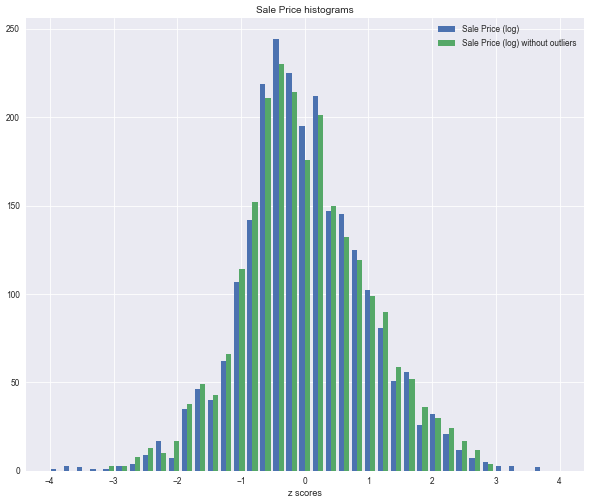

In [456]:
#In this case we come to a good agreement by selecting the z_scores of 3.0 and 2.8, but several other scenarios have been considered before making a decision on these ones.
hp_woo = hp.loc[(z_score(hp['LogSalePrice'])<2.8) & (z_score(hp['LogSalePrice'])>(-3.0)),:] 

bins = np.linspace(-4, 4, 40)
plt.figure(figsize=(12, 10), dpi= 60, facecolor='w', edgecolor='k')
plt.hist([z_score(hp.LogSalePrice.values), z_score(hp_woo.LogSalePrice.values)], bins, label=['Sale Price (log)', 'Sale Price (log) without outliers'])
plt.xlabel('z scores')
plt.title('Sale Price histograms')
plt.legend(loc='upper right')
plt.show()

In [457]:
#now we will define the engineered features. We will do this step before to be able to define some quantities such as surface per room, which we won't be able to compute if we change the dtypes for hot encoding.
hp = hp_woo.copy() #final shape 2372 x 83, which means keeping at least 97.6% of the original data and the full array of features.
hp['Room area'] = hp['Gr Liv Area']/hp['TotRms AbvGrd'] #living area per room
hp['BedBath ratio'] = (hp['Full Bath'] + hp['Half Bath'])/(hp['Bedroom AbvGr']+1) #ratio of bathrooms to bedrooms. Can't include the basement bedrooms and bathrooms because no information available on basement bedrooms. Added 1 to avoid division by zero, thus shifting the bedroom scale by one.

In [458]:
#we will also check for swekedness and if we can 'normalize' the continuous/int variables via some operations
x_values = hp.select_dtypes(['float64', 'int64']).columns.values #extract column names of int and floats and organize in list
x_skew = np.append(np.append(x_values[3:5], x_values[9:18]), np.append(x_values[28:35], x_values[40:42])) #build list of columns that could potentially undergo a 'normalizing' transformation
skew_df_log = z_score(np.log10(hp[x_skew]+1)) #z_score of log(values)+1
skew_df_sqrt = z_score(np.sqrt(hp[x_skew])) #z_score of square root (values)
skew_df_exp = z_score(1/(hp[x_skew]+1)) #z_score of inverse

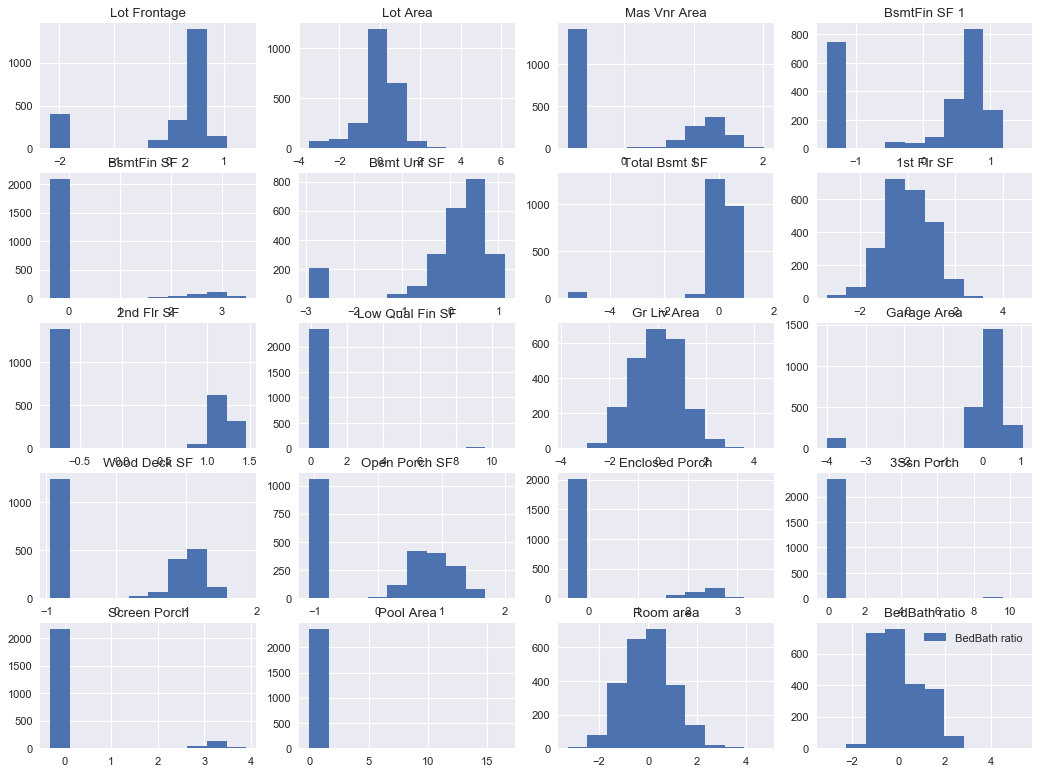

In [459]:
#plot the log histograms to visually check the type of distribution
fig, ax = plt.subplots(5, 4, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k', sharey=False) #define subplots
ax_list = list(itertools.product([0,1,2,3],repeat=2)) + [(4,0), (4,1), (4,2), (4,3)] #create a list to iterate through the axes

for i in np.arange(len(x_skew)): #loop through the number of plots as defined by the unique column names
    ax[ax_list[i]].hist(skew_df_log[x_skew[i]]) #plot corresponding hist
    ax[ax_list[i]].set_title(x_skew[i]) #plot corresponding title
    ax[ax_list[i]].set_xlabel='z score' #plot label
plt.legend()
plt.show()

#if we ignore the extreme values (which are a consequence of, for example, assigning a zero to a 'no basement area' or 'no pool area'), the log transformation could be successfully applied to the following features:
#'Lot Area', '1st Flr SF', 'Gr Liv Area', 'Garage Area', 'Room area'

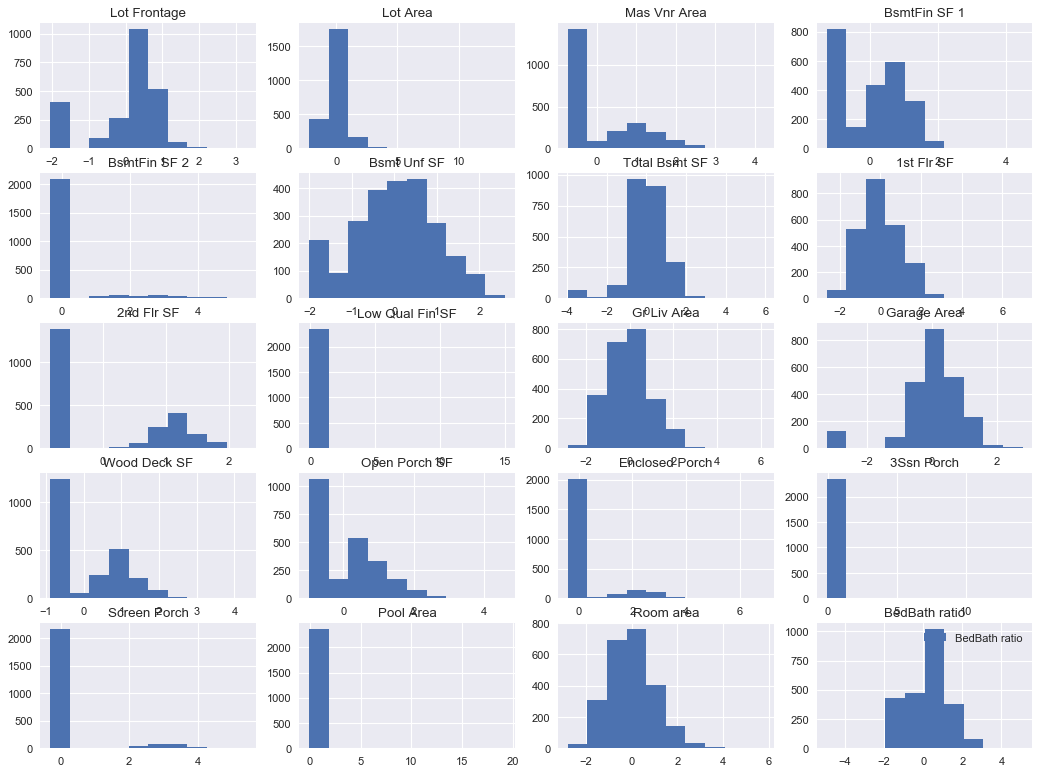

In [460]:
#plot the square root histograms to visually check the type of distribution
fig, ax = plt.subplots(5, 4, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k', sharey=False)
ax_list = list(itertools.product([0,1,2,3],repeat=2)) + [(4,0), (4,1), (4,2), (4,3)] #create a list to iterate through

for i in np.arange(len(x_skew)):
    ax[ax_list[i]].hist(skew_df_sqrt[x_skew[i]])
    ax[ax_list[i]].set_title(x_skew[i])
    ax[ax_list[i]].set_xlabel='z score'
plt.legend()
plt.show()
#proceeding in an analogous way as before, the square root transformation could be successfully applied to the following features:
#'Lot Frontage', 'Bsmt Unf SF', 'Total Bsmt SF','1st Flr SF', 'Gr Liv Area', 'Garage Area', 'Room Area', 'BedBath ratio'

In [461]:
#the inverse plots do not add any new information. Therefore, we will transform the identified variables applying either a log transformation or a square root one.
log_transform = ['Lot Area', '1st Flr SF', 'Gr Liv Area', 'Room area']
sqroot_transform = ['Lot Frontage', 'Bsmt Unf SF', 'Total Bsmt SF', 'Garage Area', 'BedBath ratio']
hp[log_transform] = np.log10(hp[log_transform])
hp[sqroot_transform] = np.sqrt(hp[sqroot_transform])

In [462]:
#before hot encoding the variables, we have to make sure that the type is the appropriate one, otherwise get_dummies will only encode the objects and not the rest unless specified.
#hp.info() to check the type of variables
#after a look at the descriptions and the types, we identify the following features (either nominal, discrete or ordinal) which need to be converted to object before progressing further with the analysis:
to_convert = ['MS SubClass', 'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr', 'Kitchen AbvGr', 'TotRms AbvGrd', 'Fireplaces', 'Garage Cars', 'Mo Sold', 'Yr Sold', 'Garage Yr Blt'] #columns to be converted
remap = dict(zip(to_convert, np.array(len(to_convert) * [object]))) #map the column names to a dictionary of {column names: object}
hp = hp.astype(remap) #change the dtype of the columns according to the dictionary key:value pairs

In [463]:
print(hf.isnull().sum()[hf.isnull().sum()>0])

Lot Frontage     13
Mas Vnr Type     23
Mas Vnr Area     23
Electrical        1
Garage Yr Blt     2
Garage Cars       1
Garage Area       1
dtype: int64


In [464]:
#once we get to this point, we can go back to the merged dataframe. 
#All the operations up to now, except for the observation dropping and the outliers removal which are specific to the train set, are found in the data_cleaning and data_engineering functions defined at the beginning.
#these functions can be directly applied to the merged dataframe.
hf = data_engineering(data_cleaning(hf)) #shape 2930 x 83, with the number of observations matching the sum of the merged dataframes
#we can see that after this operation, by checking print(hf.isnull().sum()[hf.isnull().sum()>0]), the only remaining observations with NaN are of float type, and therefore will not contribute to one-hot encoding or whatsoever.

In [465]:
#to give an example of how the onehot_encoding function defined in cell 5 performs depending on the model, we will show the necessary steps below for the case where all the columns are selected.
hf = hf.drop(columns=['Order']) #drop the Order columns as it will be of no use
hf = pd.get_dummies(hf) #we can do this directly because it has been ensured by the data engineering that all the variables that might contain categorical values are set to be of object type, and therefore will be dummied directly.

In [466]:
#once the dummies have been created, we are certain that all the factors from the categorical variables have been attributed, and we can therefore split the merged dataframe back to its train and test sets by using the PID identification.
hp_he = hf[hf['PID'].isin(house_prices_original['PID'])] #shape 2430 x 691, therefore 2430 observations as expected from the original dataframe.
hp_he = pd.merge(hp_he, house_prices_original[['PID', 'SalePrice']], how='outer') #get back the sales price column by PID into the training set.
hp_he.loc[:,'LogSalePrice'] = np.log10(hp_he.loc[:,'SalePrice']+1)
hp_500_he = hf[hf['PID'].isin(hp_500['PID'])] #500 x 691, therefore 500 observations as expected from the test set

In [467]:
#all the prior operations for one-hot encoding can be found in the onehot_encoding function defined in cell 5, for the three different models.
#the only additional operations that we will need to do after its application are the outliers removal and observations dropping from the training set. In the test set case, as the only NaNs remaining are on float64 type columns, they will be filled with the median of the column.
#Reload data for both training and test sets (to be sure we start with the correct ones)
house_prices_original = pd.read_csv('~/Desktop/EPFL Applied ML/house-prices.csv') #load data
hp_500 = pd.read_csv('~/Desktop/EPFL Applied ML/house-prices-test.csv') #load test set

In [468]:
#fit a simple model with two variables
simple = onehot_encoding('simple', house_prices_original, hp_500)[0] #we can check that the full training set simple.dtypes only has the room, neighborhood, SalePrice and LogSalePRice variables
Xs_tr, Xs_te, ys_tr, ys_te = tt_split(simple, 0.5) #extract feature and target variables for the train and test data subsets
[lr_s, hub_s, rid_s, best_alpha_s], [rmsle_s_tr, rmsle_s_te], [mae_s_tr, mae_s_te], [alphas, rmsle_s_train, rmsle_s_test] = regressions(simple, 0.5) #warnings might pop-out during the execution of this line

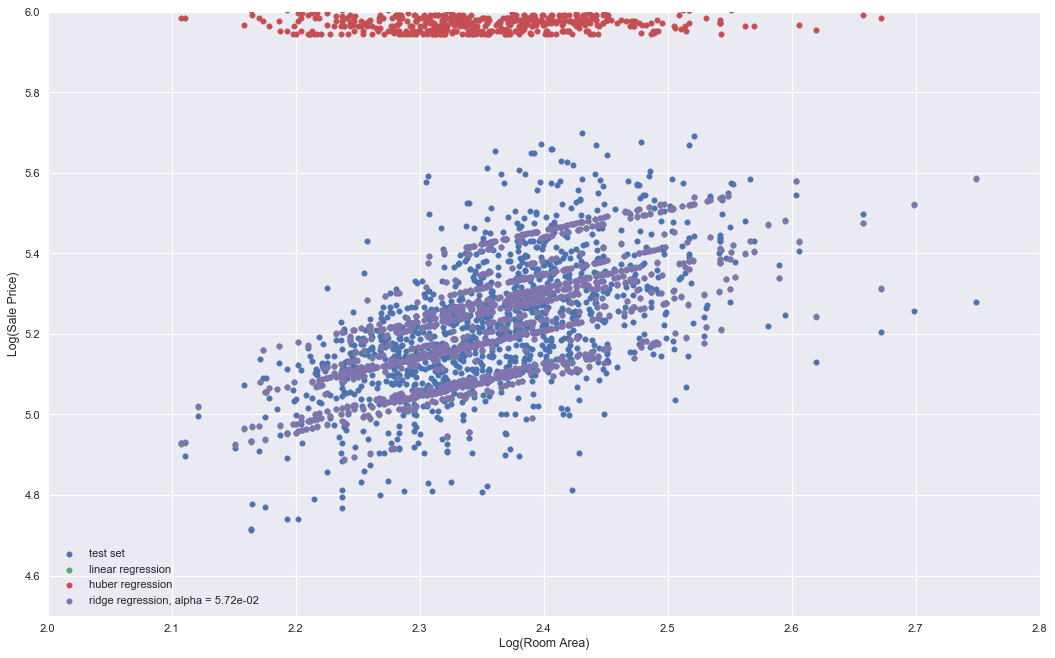

In [469]:
#plot the predictions for the log(Room Area) of the simple model
sns.set()
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xs_te[:,simple.columns.get_loc('Room area')], ys_te, label='test set', s=25)
plt.scatter(Xs_te[:,simple.columns.get_loc('Room area')], lr_s.predict(Xs_te), label='linear regression', s=25)
plt.scatter(Xs_te[:,simple.columns.get_loc('Room area')], hub_s.predict(Xs_te), label='huber regression', s=25)
plt.scatter(Xs_te[:,simple.columns.get_loc('Room area')], rid_s.predict(Xs_te), label='ridge regression, alpha = {:.2e}'.format(best_alpha_s), s=25)
plt.xlabel('Log(Room Area)')
plt.ylabel('Log(Sale Price)')
plt.xlim(2.0, 2.8)
plt.ylim(4.5, 6.0)
plt.legend()
plt.show()

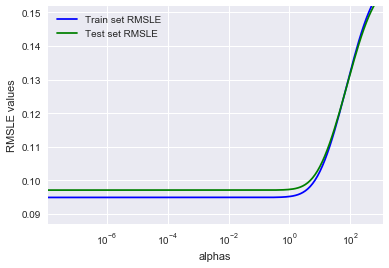

In [470]:
#plot the ridge alpha tuning for the simple model
sns.set()
plt.plot(alphas, rmsle_s_train, c='blue', label='Train set RMSLE') #plot train set rmsle VS alpha
plt.plot(alphas, rmsle_s_test, c='green', label='Test set RMSLE') #plot test set rmsle VS alpha
plt.xlabel('alphas')
plt.ylabel('RMSLE values')
plt.xscale('log')
plt.xlim(10**(best_alpha_s-8), 10**(best_alpha_s+3))
plt.ylim(rmsle_s_test[(np.where(alphas == best_alpha_s)[0][0])]-0.01, rmsle_s_test[(np.where(alphas == best_alpha_s)[0][0]+50)])
plt.legend()
plt.show()

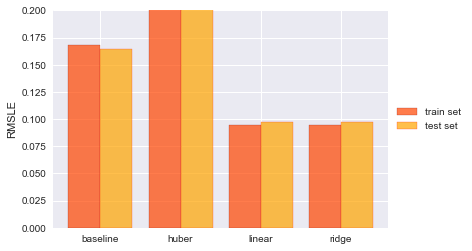

In [471]:
#plot the rmsle values for the different regressions of the simple model
sns.set()
plt.bar(['baseline', 'linear','huber','ridge'], rmsle_s_tr, width=-0.4, align='edge', color='orangered', edgecolor = 'maroon', alpha = 0.7, label='train set')
plt.bar(['baseline', 'linear','huber','ridge'], rmsle_s_te, width=0.4, align='edge', color='orange', edgecolor = 'red', alpha = 0.7, label='test set')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('RMSLE')
plt.ylim(0, 0.2)
plt.show() #it can be seen that the rmsle value is more or less constant for all the types of regression independently on the set.

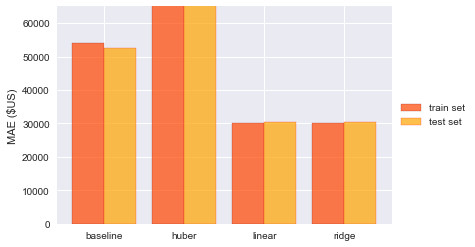

In [472]:
#plot the mae values for the different regressions of the simple model
sns.set()
plt.bar(['baseline', 'linear','huber','ridge'], mae_s_tr, width=-0.4, align='edge', color='orangered', edgecolor = 'maroon', alpha = 0.7, label='train set')
plt.bar(['baseline', 'linear','huber','ridge'], mae_s_te, width=0.4, align='edge', color='orange', edgecolor = 'red', alpha = 0.7, label='test set')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('MAE ($US)')
plt.ylim(0, 65000)
plt.show() #the same rmsle trend can be observed for the mae values

In [473]:
#fit an intermediate model with 10-20 variables.
intermediate = onehot_encoding('intermediate', house_prices_original, hp_500)[0]
Xi_tr, Xi_te, yi_tr, yi_te = tt_split(intermediate, 0.5)
[lr_i, hub_i, rid_i, best_alpha_i], [rmsle_i_tr, rmsle_i_te], [mae_i_tr, mae_i_te], [alphas, rmsle_i_train, rmsle_i_test] = regressions(intermediate, 0.5) #warnings might pop-out during the execution of this line 

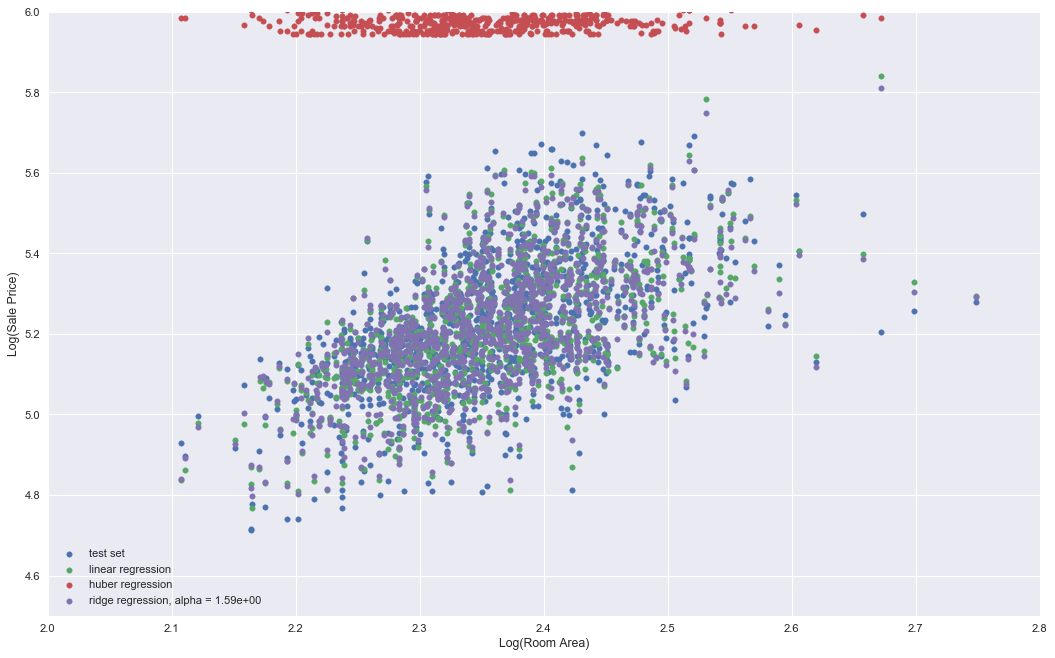

In [474]:
#plot the predictions for the log(Room Area) of the intermediate model
sns.set()
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xi_te[:,intermediate.columns.get_loc('Room area')], yi_te, label='test set', s=25)
plt.scatter(Xi_te[:,intermediate.columns.get_loc('Room area')], lr_i.predict(Xi_te), label='linear regression', s=25)
plt.scatter(Xi_te[:,intermediate.columns.get_loc('Room area')], hub_i.predict(Xi_te), label='huber regression', s=25)
plt.scatter(Xi_te[:,intermediate.columns.get_loc('Room area')], rid_i.predict(Xi_te), label='ridge regression, alpha = {:.2e}'.format(best_alpha_i), s=25)
plt.xlabel('Log(Room Area)')
plt.ylabel('Log(Sale Price)')
plt.xlim(2.0, 2.8)
plt.ylim(4.5, 6.0)
plt.legend()
plt.show()

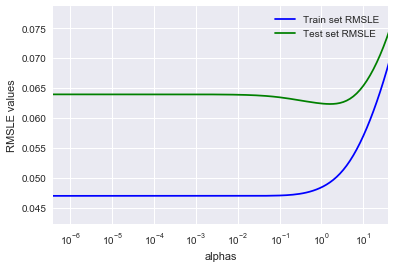

In [475]:
#plot the ridge alpha tuning for the intermediate model
sns.set()
plt.plot(alphas, rmsle_i_train, c='blue', label='Train set RMSLE') #plot train set rmsle VS alpha
plt.plot(alphas, rmsle_i_test, c='green', label='Test set RMSLE') #plot test set rmsle VS alpha
plt.xlabel('alphas')
plt.ylabel('RMSLE values')
plt.xscale('log')
plt.xlim(10**(best_alpha_i-8), 10**(best_alpha_i))
plt.ylim(rmsle_i_test[(np.where(alphas == best_alpha_i)[0][0])]-0.02, rmsle_i_test[(np.where(alphas == best_alpha_i)[0][0])+20])
plt.legend()
plt.show()

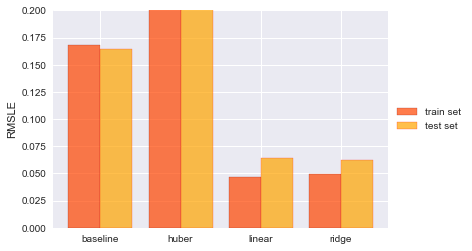

In [476]:
#plot the rmsle values for the different regressions of the intermediate model
sns.set()
plt.bar(['baseline', 'linear','huber','ridge'], rmsle_i_tr, width=-0.4, align='edge', color='orangered', edgecolor = 'maroon', alpha = 0.7, label='train set')
plt.bar(['baseline', 'linear','huber','ridge'], rmsle_i_te, width=0.4, align='edge', color='orange', edgecolor = 'red', alpha = 0.7, label='test set')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('RMSLE')
plt.ylim(0, 0.2)
plt.show() #it can be seen that the rmsle test set values have decreased compared to the simple model case. The Huber regression seems not to give good results, even if optimized and using a more complicated 

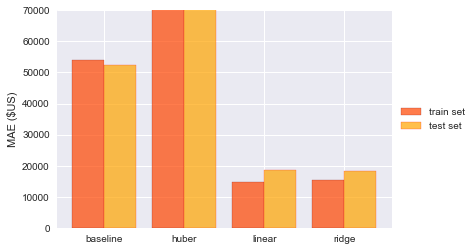

In [477]:
#plot the mae values for the different regressions of the intermediate model
sns.set()
plt.bar(['baseline', 'linear','huber','ridge'], mae_i_tr, width=-0.4, align='edge', color='orangered', edgecolor = 'maroon', alpha = 0.7, label='train set')
plt.bar(['baseline', 'linear','huber','ridge'], mae_i_te, width=0.4, align='edge', color='orange', edgecolor = 'red', alpha = 0.7, label='test set')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('MAE ($US)')
plt.ylim(0, 70000)
plt.show() #the same rmsle trend can be observed for the mae values

In [478]:
#fit a complex model with all the variables.
complex_model = onehot_encoding('complex', house_prices_original, hp_500)[0]
Xc_tr, Xc_te, yc_tr, yc_te = tt_split(complex_model, 0.5)
[lr_c, hub_c, rid_c, best_alpha_c], [rmsle_c_tr, rmsle_c_te], [mae_c_tr, mae_c_te], [alphas, rmsle_c_train, rmsle_c_test] = regressions(complex_model, 0.5) #warnings might pop-out during the execution of this line 

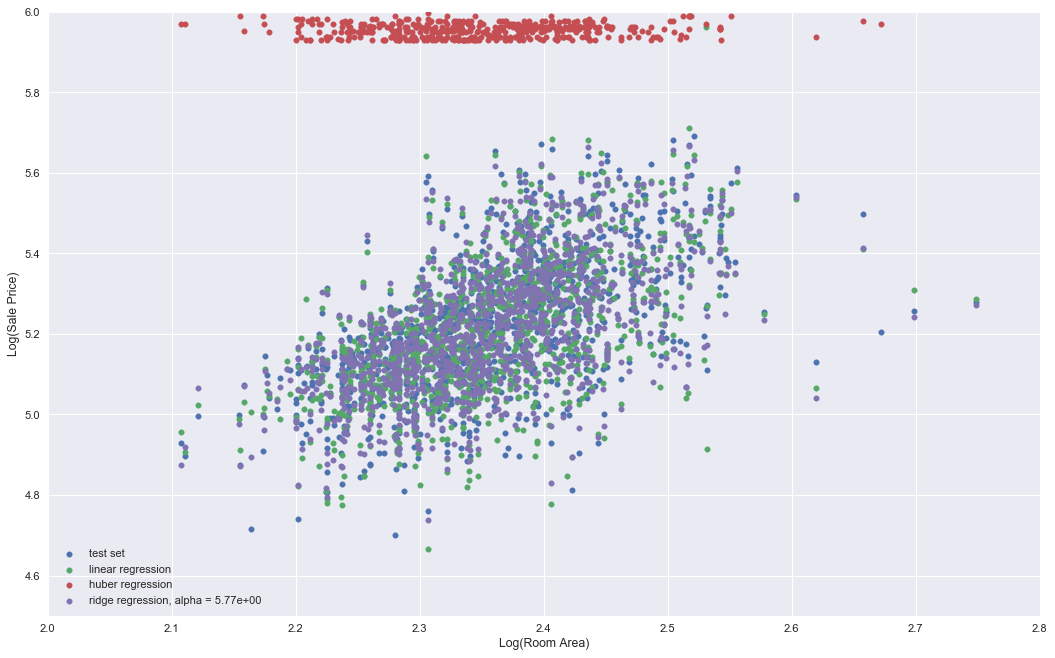

In [479]:
#plot the predictions for the log(Room Area) of the complex model
sns.set()
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(Xc_te[:,complex_model.columns.get_loc('Room area')], yc_te, label='test set', s=25)
plt.scatter(Xc_te[:,complex_model.columns.get_loc('Room area')], lr_c.predict(Xc_te), label='linear regression', s=25)
plt.scatter(Xc_te[:,complex_model.columns.get_loc('Room area')], hub_c.predict(Xc_te), label='huber regression', s=25)
plt.scatter(Xc_te[:,complex_model.columns.get_loc('Room area')], rid_c.predict(Xc_te), label='ridge regression, alpha = {:.2e}'.format(best_alpha_c), s=25)
plt.xlabel('Log(Room Area)')
plt.ylabel('Log(Sale Price)')
plt.xlim(2.0, 2.8)
plt.ylim(4.5, 6.0)
plt.legend()
plt.show() #huber regression seems to greatly diverge in this case. Might pay to do an epsilon and/or alpha sweep to see if the prediction could be improved.

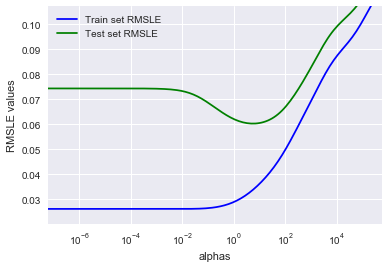

In [480]:
#plot the ridge alpha tuning for the complex model
sns.set()
plt.plot(alphas, rmsle_c_train, c='blue', label='Train set RMSLE') #plot train set rmsle VS alpha
plt.plot(alphas, rmsle_c_test, c='green', label='Test set RMSLE') #plot test set rmsle VS alpha
plt.xlabel('alphas')
plt.ylabel('RMSLE values')
plt.xscale('log')
plt.xlim(10**(best_alpha_c-13), 10**(best_alpha_c))
plt.ylim(rmsle_c_test[(np.where(alphas == best_alpha_c)[0][0])]-0.04, rmsle_c_test[(np.where(alphas == best_alpha_c)[0][0])+50])
plt.legend()
plt.show()

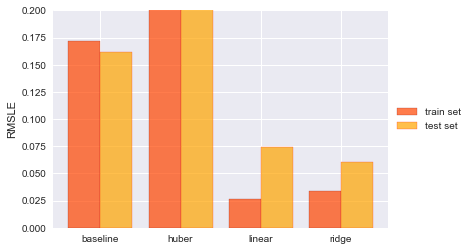

In [481]:
#plot the rmsle values for the different regressions of the complex model
sns.set()
plt.bar(['baseline', 'linear','huber','ridge'], rmsle_c_tr, width=-0.4, align='edge', color='orangered', edgecolor = 'maroon', alpha = 0.7, label='train set')
plt.bar(['baseline', 'linear','huber','ridge'], rmsle_c_te, width=0.4, align='edge', color='orange', edgecolor = 'red', alpha = 0.7, label='test set')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylabel('RMSLE')
plt.ylim(0, 0.20)
plt.show() #the only test set RMSLE value that does not diverge is the ridge one, which is smaller than all the other models (simple and intermediate). This might be an indication of ill-conditioning or overfitting. 

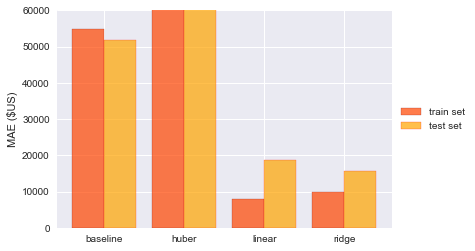

In [482]:
#plot the mae values for the different regressions of the complex model
sns.set()
plt.bar(['baseline', 'linear','huber','ridge'], mae_c_tr, width=-0.4, align='edge', color='orangered', edgecolor = 'maroon', alpha = 0.7, label='train set')
plt.bar(['baseline', 'linear','huber','ridge'], mae_c_te, width=0.4, align='edge', color='orange', edgecolor = 'red', alpha = 0.7, label='test set')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.ylim(0, 60000)
plt.ylabel('MAE ($US)')
plt.show() #the same rmsle trend can be observed for the mae values

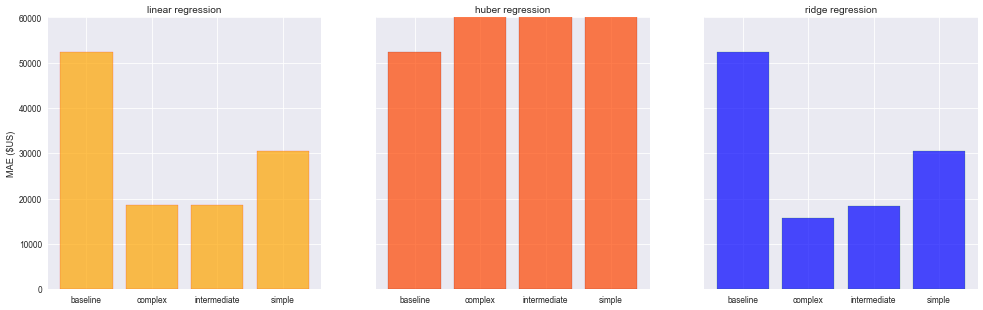

In [483]:
#Compare the MAE value for different models.
sns.set()
fig_mae, ax_mae = plt.subplots(1, 3, sharey=True, figsize=(20, 6), dpi=60)
ax_mae[0].bar(['baseline', 'simple','intermediate','complex'], [mae_s_te[0], mae_s_te[1], mae_i_te[1], mae_c_te[1]], color='orange', edgecolor = 'red', alpha = 0.7, label='linear regression')
ax_mae[0].set_title('linear regression')
ax_mae[1].bar(['baseline', 'simple','intermediate','complex'], [mae_s_te[0], mae_s_te[2], mae_i_te[2], mae_c_te[2]], color='orangered', edgecolor = 'maroon', alpha = 0.7, label='huber regression')
ax_mae[1].set_title('huber regression')
ax_mae[2].bar(['baseline', 'simple','intermediate','complex'], [mae_s_te[0], mae_s_te[3], mae_i_te[3], mae_c_te[3]], color='blue', edgecolor = 'green', alpha = 0.7, label='ridge regression')
ax_mae[2].set_title('ridge regression')
ax_mae[0].set_ylabel('MAE ($US)')
ax_mae[0].set_ylim(0, 60000)
plt.show()
#it can be seen that the mae for the linear regression diverges for all the models (only the baseline survives). 
#the ridge regression for the complex model gives the best results in terms of MAE, so we will use it for the predictions on the external test set.

In [484]:
#compute the predictions for the 500 houses from the external test set, using the ridge regression models.
ts_500_simple = onehot_encoding('simple', house_prices_original, hp_500)[1]
ts_500_intermediate = onehot_encoding('intermediate', house_prices_original, hp_500)[1]
ts_500_complex = onehot_encoding('complex', house_prices_original, hp_500)[1]

ts_500_simple['SalePricePrediction'] = 10**rid_s.predict(ts_500_simple.values)
ts_500_intermediate['SalePricePrediction'] = 10**rid_i.predict(ts_500_intermediate.values)
ts_500_complex['SalePricePrediction'] = 10**rid_c.predict(ts_500_complex.values)

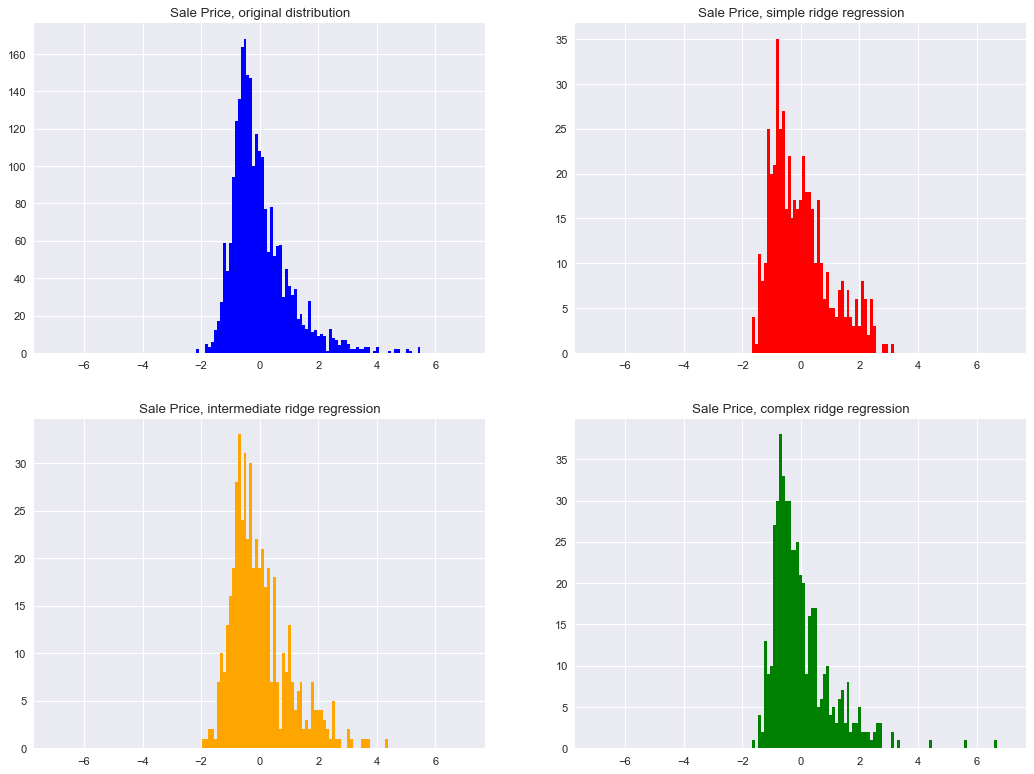

In [485]:
#plot the histograms to check the price distributions for the different ridge regression models (we have chosen this case as the MAE values are clearly different each model (simple, intermediate, complex)).
sns.set()
bins = np.linspace(-7, 7, 140)

fig2, ax2 = plt.subplots(2, 2, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k', sharey=False)
ax2[0][0].hist(z_score(house_prices_original.SalePrice.values), bins, color='blue')
ax2[0][0].set_title('Sale Price, original distribution')
ax2[0][1].hist(z_score(ts_500_simple.SalePricePrediction.values), bins, color='red')
ax2[0][1].set_title('Sale Price, simple ridge regression')
ax2[1][0].hist(z_score(ts_500_intermediate.SalePricePrediction.values), bins, color='orange')
ax2[1][0].set_title('Sale Price, intermediate ridge regression')
ax2[1][1].hist(z_score(ts_500_complex.SalePricePrediction.values), bins, color='green')
ax2[1][1].set_title('Sale Price, complex ridge regression')
plt.show()

In [486]:
#we can also compare the metrics of the distributions in the case of the original dataframe and the predicted values for the ridge regression. As for the distributions, it can be observed that the metrics are quite similar for all the models tested, with the complex model offering the best MAE values of all.
original_dist = pd.DataFrame(house_prices_original.SalePrice.describe())
predicted_dist_simple = pd.DataFrame(ts_500_simple.SalePricePrediction.describe())
predicted_dist_simple.columns = ['Predicted Sale Price, simple ridge model']
predicted_dist_intermediate = pd.DataFrame(ts_500_intermediate.SalePricePrediction.describe())
predicted_dist_intermediate.columns = ['Predicted Sale Price, intermediate ridge model']
predicted_dist_complex = pd.DataFrame(ts_500_complex.SalePricePrediction.describe())
predicted_dist_complex.columns = ['Predicted Sale Price, complex ridge model']
comparison = pd.concat([original_dist, predicted_dist_simple, predicted_dist_intermediate, predicted_dist_complex], axis = 1, join = 'inner').round(decimals=0)
comparison


,SalePrice,"Predicted Sale Price, simple ridge model","Predicted Sale Price, intermediate ridge model","Predicted Sale Price, complex ridge model"
count,2430.0,500.0,500.0,500.0
mean,180200.0,176216.0,181799.0,183263.0
std,79607.0,60468.0,72692.0,83102.0
min,12789.0,80033.0,45106.0,50206.0
25%,129000.0,128168.0,131582.0,127344.0
50%,160000.0,166286.0,164712.0,161453.0
75%,213100.0,209767.0,215022.0,215955.0
max,755000.0,362037.0,498801.0,735405.0


In [487]:
final_prediction = ts_500_complex[['PID', 'SalePricePrediction']]
final_prediction.to_csv('house-prices-pred.csv', index=False, float_format='%.0f')